#### Seq2Seq ML model for German to English translation

Data: https://www.manythings.org/anki/ 

Simplified from PyTorch tutorial here: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [1]:
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The most common sequence-to-sequence (seq2seq) models are encoder-decoder models, which (commonly) use a recurrent neural network (RNN) to encode the source (input) sentence into a single vector.

#### we will be representing each word in a language as a one-hot vector.We’ll need a unique index per word to use as the inputs and targets of the networks later.

we will use a helper class called Lang which has word → index (word2index) and index → word (index2word) dictionaries, as well as a count of each word word2count to use to later replace rare words.

In [3]:
SOS_token = 0 # start of sentence
EOS_token = 1 # end of sentence

In [4]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  

    def addSentence(self, sentence):
        for word in sentence.split(' '): # for every word in the sentence:
            self.addWord(word)  # call addword() function

    def addWord(self, word): 
        if word not in self.word2index: 
            self.word2index[word] = self.n_words # add each new word and its index to word2index dict
            self.word2count[word] = 1 # add each new word to word2count dict with value equals 1
            self.index2word[self.n_words] = word # add index of each new word to index2word dict 
                                                 # with its value equals to the word itself
            self.n_words += 1
        else:                                   
            self.word2count[word] += 1 # for each reoccuring word, only increase value in word2count

#### The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [5]:
s = "Hellooo."
re.sub(r"([.!?])", r" \1", s)

'Hellooo .'

In [6]:
s = "Hellooo.9^"
re.sub(r"[^a-zA-Z.!?]+", r" ", s)

'Hellooo. '

In [7]:
def normalizeString(s): # input: unicode, output: ascii
    
    s = s.lower().strip()
    
    s = ''.join( # to convert characters from unicode to ascii. ex: É --> E
        char for char in unicodedata.normalize('NFD', s)
        if unicodedata.category(char) != 'Mn')
    
    s = re.sub(r"([.!?])", r" \1", s) # add sapace before .!?  
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) # non-letters and digits replaced by space
    
    return s

#### - To read the data file we will split the file into lines
#### - then split lines into pairs and normalize
#### - The files are all English → German, to translate German → English add reverse flag to reverse the pairs

In [8]:
def readLangs(lang1, lang2, reverse=False):
    
    print("Reading lines...")
    
    # reads all input sentences from 2 given laguages, split them into lines and store them in a list
    lines = open('datasets/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8'). \
                  read().strip().split('\n')
    
    # all pairs are splitted by a tab \t
    # split each pair, normlize them and store each pair in a list
    # pairs is a list of list (each pair element is stored in a list inside a list of all pairs)
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse: # reverse the input and source languages in each pair element
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2) # object of class lang, automatically creates word2index 
                                 # word2count and index2word dictioanry
            
        output_lang = Lang(lang1) # object of class lang
    else:
        input_lang = Lang(lang1) # object of class lang
        output_lang = Lang(lang2) # object of class lang

    return input_lang, output_lang, pairs

In [9]:
readLangs('eng', 'deu', reverse=False)

Reading lines...


(<__main__.Lang at 0x16c710d3cc8>,
 [['hi .', 'hallo !'],
  ['hi .', 'gru gott !'],
  ['run !', 'lauf !'],
  ['wow !', 'potzdonner !'],
  ['wow !', 'donnerwetter !'],
  ['fire !', 'feuer !'],
  ['help !', 'hilfe !'],
  ['help !', 'zu hulf !'],
  ['stop !', 'stopp !'],
  ['wait !', 'warte !'],
  ['go on .', 'mach weiter .'],
  ['hello !', 'hallo !'],
  ['i ran .', 'ich rannte .'],
  ['i see .', 'ich verstehe .'],
  ['i see .', 'aha .'],
  ['i try .', 'ich probiere es .'],
  ['i won !', 'ich hab gewonnen !'],
  ['i won !', 'ich habe gewonnen !'],
  ['smile .', 'lacheln !'],
  ['cheers !', 'zum wohl !'],
  ['freeze !', 'keine bewegung !'],
  ['freeze !', 'stehenbleiben !'],
  ['got it ?', 'kapiert ?'],
  ['got it ?', 'verstanden ?'],
  ['got it ?', 'einverstanden ?'],
  ['he ran .', 'er rannte .'],
  ['he ran .', 'er lief .'],
  ['hop in .', 'mach mit !'],
  ['hug me .', 'druck mich !'],
  ['hug me .', 'nimm mich in den arm !'],
  ['hug me .', 'umarme mich !'],
  ['i fell .', 'ich fiel .'

#### Since there are a lot of example sentences and we want to train something quickly, we’ll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes ending punctuation) and we’re filtering to sentences that translate to the form “I am” or “He is” etc. (accounting for apostrophes replaced earlier).
- `I'm` -->`I m`
- `They're` --> `They re`

In [10]:
MAX_LENGTH = 10

In [11]:
eng_prefixes = ("i am ", "i m ",
                "he is", "he s ",
                "she is", "she s ",
                "you are", "you re ",
                "we are", "we re ",
                "they are", "they re ")

In [12]:
def filterPairs(pairs):
    return [p for p in pairs 
            if 
            len(p[0].split(' ')) < MAX_LENGTH and 
            len(p[1].split(' ')) < MAX_LENGTH and 
            p[1].startswith(eng_prefixes)]

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs

In [13]:
def prepareData(lang1, lang2, reverse=False):
    
    # real all data and convert them into list of pairs
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    # filter the only pairs that meet our constraints
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    for pair in pairs: # add pairs to input_lang and output_lang objects
    # these are objects of class lang which automatically creates word2index and index2word mapping
        input_lang.addSentence(pair[0]) # add all words in input language to the input_lang object
        output_lang.addSentence(pair[1]) # add all words in output language to the output_lang object
        
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, pairs

In [14]:
input_lang, output_lang, pairs = prepareData('eng', 'deu', reverse=True)

print(random.choice(pairs))

Reading lines...
Read 176692 sentence pairs
Trimmed to 9678 sentence pairs
Counted words:
deu 4494
eng 2913
['ich bin schuld nicht du .', 'i m to blame not you .']


In [15]:
"""
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")`
"""

'\n# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it\'ll return False\nis_cuda = torch.cuda.is_available()\n\n# If we have a GPU available, we\'ll set our device to GPU. We\'ll use this device variable later in our code.\nif is_cuda:\n    device = torch.device("cuda")\nelse:\n    device = torch.device("cpu")`\n'

## Encoder-Decoder
A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence


<img src="Images/encoder-decoder.JPG">


### Encoder:
-  sequence --> vector
- there is no `output_size` in  the Encoder

<img src="Images/Encoder.JPG">

### With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector
- a single point in some N dimensional space of sentences. 

In [16]:
class EncoderRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size):# there is no output_size in Encoder
        super(EncoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        # words enter in the form of one-hot encoding and delivered as embedding
        # we use hidden_size for both self.embedding and self.gru
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # inputs are: the embedding of the current source language word as well as       
        #  the output of the previous time step of the GRU cell (previous word)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # attention! we have 2 inputs in forward pass, current word and hidden state of previous word
        
        # [1, hidden_size] -> [1, 1, hidden_size]
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        
        # we have 2 inputs in every time-step, current word and the previous hidden-state of encoder
        output, hidden = self.gru(output, hidden)
        
        return output, hidden

    def initHidden(self):
        # initialize hidden state for the 1st word to all zeros
        return torch.zeros(1, 1, self.hidden_size)

### The final hidden output of the encoder is what we feed in to the decoder

## Basic Decoder

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string SOS token, and the first hidden state is the context vector (the encoder’s last hidden state).

<img src="Images/Decoder.JPG">

In [17]:
class DecoderRNN(nn.Module):
    
    # hidden_size is the size of last hidden output of encoder
    # output_size is the size of vocabulary of target language
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        
        # hidden size of encoder
        self.hidden_size = hidden_size
        
        # embedding of every word in the target language
        self.embedding = nn.Embedding(output_size, hidden_size)
        
        # inputs are: last hidden output of encoder as well as last predicted word by decoder
        self.gru = nn.GRU(hidden_size, hidden_size)
        
        self.out = nn.Linear(hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        
        # input is the previous (1st) word predicted by GRU
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        
        # hidden is at first the last hidden state of encoder then, previous hidden-state of decoder
        output, hidden = self.gru(output, hidden)
        
        # [1, 1, hidden_size] -> [1, hidden_size]
        output = self.softmax(self.out(output[0]))
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

#### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [18]:
# converts sentences into the one-hot encoded feature vectors
def tensorFromSentence(lang, sentence):
    
    # produces a list of indices representing every word in the sentence
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    
    # every sentence is followed ba EOS_token (all sentences ends with 1)
    indexes.append(EOS_token)
    
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

In [19]:
# gets a pair of sentences ang gives a tuple consists of input and target tensors (list of indices)
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    
    return (input_tensor, target_tensor)

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the SOS token as its first input, and the last hidden state of the encoder as its first hidden state.

<b>“Teacher forcing” </b> is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input.
    
    

### Decoder is given the SOS token as its first input, and the last hidden state of the encoder as its first hidden state and generates the translated sentence one word at a time

In [20]:
teacher_forcing_ratio = 0.5
# 50% of times, decoder uses the real target word to predict the next word 
# instead of what the decoder is predicted (decoder previous output)

In [42]:
def train(input_tensor, target_tensor, 
          encoder, decoder,
          encoder_optimizer, decoder_optimizer, 
          criterion, max_length=MAX_LENGTH):
    
    # set encoder hidden-state to all zeros
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    
    input_length = input_tensor.size(0) # number of words in input vector
    target_length = target_tensor.size(0) # number of words in target vector
       
    
    loss = 0

    for ei in range(input_length): # input_length is the number of words in the input sentence
        
        # we have 2 inputs in every time-step, current word and the previous hidden-state of encoder
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
    
    # the 1st input to the decoder is SOS_token which is 0
    decoder_input = torch.tensor([[SOS_token]])
    
    # the first hidden-state of decoder is the last hidden-state of the encoder (contains all the info)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
       
        for di in range(target_length): # iterate through all words in the target language
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden) # real words are fed to the decoder
            
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di] # input to the next time-step is the actual word
                                              # and not the predicted word from the decoder
    else:
        
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
            # we use decoder ouput to find the predicted word
            # and we use this prediction as an input to the decoder for the next prediction
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token: # if True, emd of sentence has reached
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

In [22]:
plot_losses = []
print_loss_total = 0  
plot_loss_total = 0 

In [23]:
hidden_size = 256

In [24]:
#input_size of encoder is the number of words in source language
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)

#output_size of decoder is the number of words in target language
decoder1 = DecoderRNN(hidden_size, output_lang.n_words)

In [26]:
encoder_optimizer = optim.SGD(encoder1.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(decoder1.parameters(), lr=0.01)

# create 30000 sample pairs
training_pairs = [tensorsFromPair(random.choice(pairs))
                  for i in range(30000)]
criterion = nn.NLLLoss()

In [41]:
training_pair = training_pairs[0]
print(training_pair)
input_tensor = training_pair[0]
target_tensor = training_pair[1]
print("For this specific example:")
print("\tinput_tensor size:",input_tensor.size(0) , "\n\ttarget_tensor size:", target_tensor.size(0))

(tensor([[   2],
        [  68],
        [  11],
        [ 127],
        [  19],
        [1619],
        [   6],
        [   1]]), tensor([[   2],
        [   3],
        [  88],
        [  51],
        [ 295],
        [1076],
        [  81],
        [ 421],
        [   4],
        [   1]]))
For this specific example:
	input_tensor size: 8 
	target_tensor size: 10


iteration - 1000 loss - 35.9555
iteration - 2000 loss - 31.7013
iteration - 3000 loss - 29.9132
iteration - 4000 loss - 29.0157
iteration - 5000 loss - 28.1504
iteration - 6000 loss - 27.7211
iteration - 7000 loss - 26.4905
iteration - 8000 loss - 25.9118
iteration - 9000 loss - 24.8833
iteration - 10000 loss - 24.3283
iteration - 11000 loss - 23.7101
iteration - 12000 loss - 22.4644
iteration - 13000 loss - 22.2128
iteration - 14000 loss - 21.3743
iteration - 15000 loss - 21.1767
iteration - 16000 loss - 20.3853
iteration - 17000 loss - 19.6568
iteration - 18000 loss - 19.8453
iteration - 19000 loss - 18.9356
iteration - 20000 loss - 18.0735
iteration - 21000 loss - 17.7476
iteration - 22000 loss - 17.5800
iteration - 23000 loss - 17.2169
iteration - 24000 loss - 16.3748
iteration - 25000 loss - 15.8504
iteration - 26000 loss - 15.9825
iteration - 27000 loss - 15.5198
iteration - 28000 loss - 15.5111
iteration - 29000 loss - 14.7632
iteration - 30000 loss - 14.2774


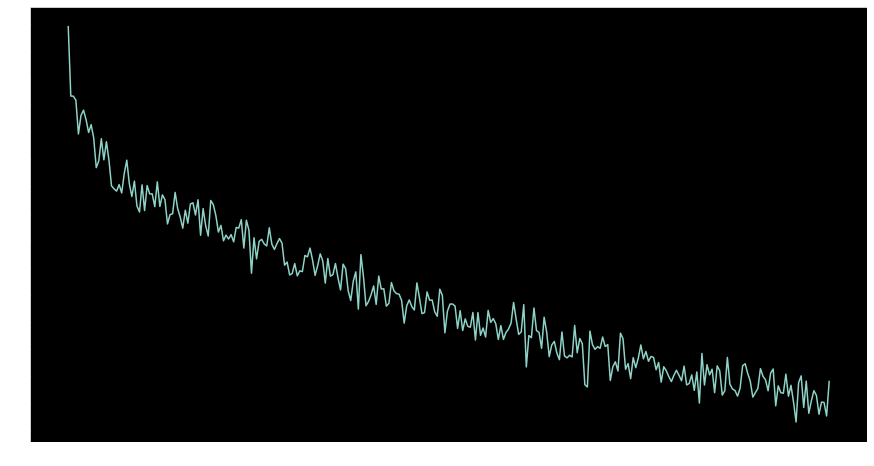

In [26]:
for iter in range(1, 30001):
    
    training_pair = training_pairs[iter - 1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    loss = train(input_tensor, target_tensor, 
                 encoder1, decoder1, 
                 encoder_optimizer, decoder_optimizer, 
                 criterion)
    
    print_loss_total += loss
    plot_loss_total += loss

    if iter % 1000 == 0:
        print_loss_avg = print_loss_total / 100 # 1000 is better actually
        print_loss_total = 0
        print('iteration - %d loss - %.4f' % (iter, print_loss_avg))

    if iter % 100 == 0:
        plot_loss_avg = plot_loss_total / 100
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

fig, ax = plt.subplots(figsize=(15, 8))
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(plot_losses)

#### KEY: > input = target < output

#### Evaluation
there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. 

In [39]:
def evaluate(encoder, decoder, sentence):
    
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size(0)
        
        encoder_hidden = encoder.initHidden()

        for ei in range(input_length): # for each word in input sentence
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]]) # SOS_token is the 1st input to decoder
        decoder_hidden = encoder_hidden # final hidden_state of encoder is the inital hidden_state of decoder 

        decoded_words = []

        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden = decoder(decoder_input, 
                                                     decoder_hidden)
            # highest predicted probability is the predicted output of decoder
            topv, topi = decoder_output.data.topk(1)
            
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
                
            else:
                # convert index of predicted word to the actual word in target language ans append it
                decoded_words.append(output_lang.index2word[topi.item()])
            
            # the previously predicted word is the input to the decoder for the next time-step
            decoder_input = topi.squeeze().detach()

        return decoded_words

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [40]:
for i in range(10):
        
        pair = random.choice(pairs)
        
        print('input>', pair[0])
        print('actual =', pair[1])
        
        output_words = evaluate(encoder1, decoder1, pair[0])
        output_sentence = ' '.join(output_words)
        
        print('output<', output_sentence)
        print('')

> ich bin neu .
= i m new .
< i m a . . <EOS>

> er ist bei seinen leuten beliebt .
= he is popular with his men .
< he is popular with his . . <EOS>

> wir sind uns seiner ehrlichkeit sicher .
= we are sure of his honesty .
< we are pretty to be now . <EOS>

> du bist der beste papa aller zeiten !
= you re the best dad ever .
< you re in the only who . <EOS>

> er ist ein sehr netter schuler .
= he is a very nice student .
< he is a very student . <EOS>

> er kommt oft zu spat in die schule .
= he is often late for school .
< he is going to school school . <EOS>

> du bist eine gro e hilfe .
= you re very helpful .
< you re very big . <EOS>

> sie verspotten dich .
= they re mocking you .
< they re about you . <EOS>

> ich fuhle mich sehr geschmeichelt .
= i m flattered .
< i m very careful . <EOS>

> ich bin jetzt drei ig .
= i m thirty now .
< i m about to now . <EOS>



In [41]:
input_sentence = 'es tut mir sehr leid' #Re-run for 'es geht mir gut'

In [42]:
output_words = evaluate(encoder1, 
                        decoder1, 
                        input_sentence)

In [43]:
print('input =', input_sentence)
print('output =', ' '.join(output_words))

input = es tut mir sehr leid
output = i m very sorry . <EOS>


### Save the model

In [44]:
torch.save(encoder1.state_dict(), 'encoder1_saved_weights.pt')
torch.save(decoder1.state_dict(), 'decoder1_saved_weights.pt')


### Load the saved model

In [45]:
hidden_size = 256

In [46]:
encoder_loaded = EncoderRNN(input_lang.n_words, hidden_size)
decoder_loaded = DecoderRNN(hidden_size, output_lang.n_words)

In [47]:
encoder_loaded.load_state_dict(torch.load('encoder1_saved_weights.pt'))
decoder_loaded.load_state_dict(torch.load('decoder1_saved_weights.pt'))

<All keys matched successfully>

In [53]:
test = 'sie machen einen salat'

In [54]:
output_words = evaluate(encoder_loaded, 
                        decoder_loaded, 
                        test)

In [50]:
print('input =', test)
print('output =', ' '.join(output_words))

input = sie machen einen salat
output = you re making a big . <EOS>
